In [40]:
import importlib
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

sys.path.append("../../")

from astroLuSt.datascience import (
    layers as aldala,
    totables as aldato
)
from astroLuSt.styles import plot_styles as alstps

importlib.reload(alstps)

#style for plotting
_ = alstps.tre_light()

# Convert Hyperparameter Grid to Latex

In [32]:
hypgrid = dict(
    epochs=100,
    learning_rate=1e-3,
    intermediate_dim=512,
    latent_dim=2,
    beta_1=0.9,
    beta_2=0.999,
    clipnorm=1.0,
)

hypgrid_ltx = aldato.hypergrid2latex(hypergrid=hypgrid)
print(hypgrid_ltx)

\begin{table}[!th]
\caption{Hyperparameter-Grid}
\label{tab:YOURLABEL}
\begin{tabular}{ll}
\toprule
Parameter & Value \\
\midrule
epochs & 100.0 \\
learning_rate & 0.001 \\
intermediate_dim & 512.0 \\
latent_dim & 2.0 \\
beta_1 & 0.9 \\
beta_2 & 0.999 \\
clipnorm & 1.0 \\
\bottomrule
\end{tabular}
\end{table}



## Define a Model (VAE)

In [38]:
class VariationalAutoencoder:
    def __init__(self, input_shape, original_dim, intermediate_dim, latent_dim):
        self.input_shape = input_shape
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim

    def build_model(self):
        # instantiate VAE model
        self.build_encoder()
        self.build_decoder()

        self.outputs = self.decoder(self.encoder(self.inputs)[2])

        self.vae = keras.models.Model(self.inputs, self.outputs, name='vae_mlp')
        self.add_loss()

        return self.vae

    def build_encoder(self):
        self.inputs = keras.layers.Input(shape=self.input_shape, name='encoder_input')
        x = keras.layers.Dense(self.intermediate_dim, activation='relu')(self.inputs)
        self.z_mean = keras.layers.Dense(self.latent_dim, name='z_mean')(x)
        self.z_log_var = keras.layers.Dense(self.latent_dim, name='z_log_var')(x)

        self.z = aldala.Sampling(name="z")([self.z_mean, self.z_log_var])


        # instantiate encoder model
        self.encoder = keras.models.Model(self.inputs, [self.z_mean, self.z_log_var, self.z], name='encoder')

    def build_decoder(self):
        latent_inputs = keras.layers.Input(shape=(self.latent_dim,), name='z_sampling')
        x = keras.layers.Dense(self.intermediate_dim, activation='relu')(latent_inputs)
        outputs = keras.layers.Dense(self.original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = keras.models.Model(latent_inputs, outputs, name='decoder')

    def add_loss(self):
        # VAE loss = mse_loss or xent_loss + kl_loss
        reconstruction_loss = keras.losses.mse(self.inputs, self.outputs)
        reconstruction_loss *= self.original_dim

        kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.vae.add_loss(vae_loss)



        # keras.backend.clear_session()


In [39]:
#init the model
VAE = VariationalAutoencoder(
    input_shape=784, 
    original_dim=784, 
    intermediate_dim=hypgrid["intermediate_dim"],
    latent_dim=hypgrid["latent_dim"],
)
opt = Adam(learning_rate=hypgrid["learning_rate"], beta_1=hypgrid["beta_1"], beta_2=hypgrid["beta_2"], clipnorm=hypgrid["clipnorm"])

model = VAE.build_model()
model.compile(optimizer=opt)


ValueError: Cannot convert '784' to a shape.

In [5]:
#train the model
##load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#rescale
X_train = X_train/255
X_test = X_test/255

# #test plot
# fig = plt.figure()
# plt.imshow(X_train[0])
# plt.show()

#reshape to 1d
n2use = 10000
X_train = tf.reshape(X_train, (-1, 28*28))[:n2use]
X_test = tf.reshape(X_test, (-1, 28*28))[:n2use]
y_train = y_train[:n2use]
y_test = y_test[:n2use]
print(X_train.shape, X_test.shape)

hist = model.fit(
    X_train, X_train, 
    epochs=100,
    batch_size=64,
    callbacks=None
)

(10000, 784) (10000, 784)


2024-11-08 17:42:30.198433: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


NameError: name 'model' is not defined

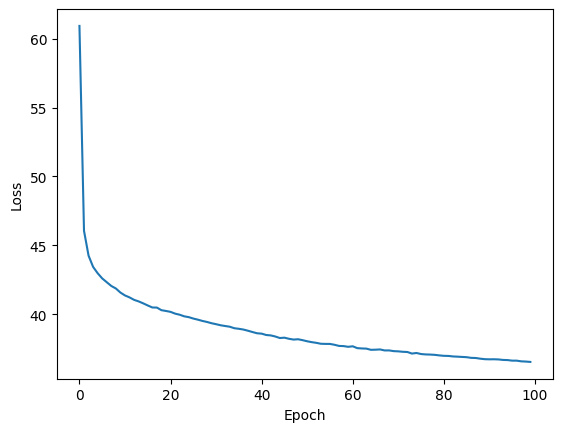

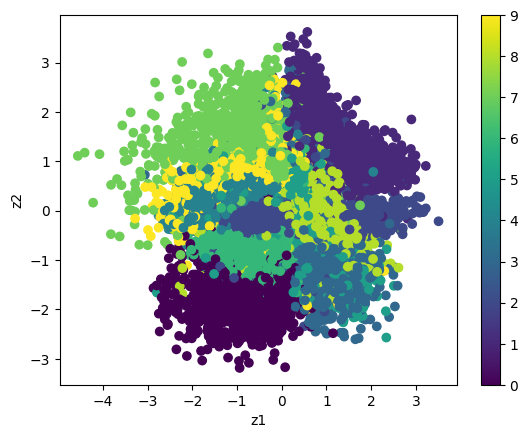

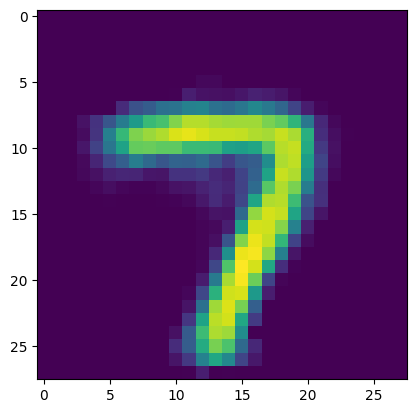

In [6]:
#visualize results
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(hist.history["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")


z_mu, z_log_var, z = VAE.encoder(X_train)

fig = plt.figure()
ax1 = fig.add_subplot(111)
sctr = ax1.scatter(z[:,0], z[:,1], c=y_train)
cbar = fig.colorbar(sctr, ax=ax1)
ax1.set_xlabel("z1")
ax1.set_ylabel("z2")

X_gen = VAE.decoder(tf.constant([[-1,2]]))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(tf.reshape(X_gen[0], (28, 28)))
plt.show()

plt.show()

# Store Model Summary

In [13]:
importlib.reload(aldato)
df_sum_enc = aldato.summary2pandas_keras(
    model=VAE.encoder,
    width=250,
    latex_to_file="../_data/vaeenc_summary.tex",
    write_mode="w",
    save="../_data/vaeenc_summary.csv",
    verbose=0,
)
df_sum_dec = aldato.summary2pandas_keras(
    model=VAE.decoder,
    width=250,
    latex_to_file="../_data/vaedec_summary.tex",
    write_mode="w",
    save="../_data/vaedec_summary.csv",
    verbose=0,
)
display(df_sum_enc)
display(df_sum_dec)

encoder                                                        \
           Layer        Type   Output Shape Param # Activation Filters   
0  encoder_input  InputLayer  [(None, 784)]       0       None    None   
1          dense       Dense    (None, 512)  401920       relu    None   
2         z_mean       Dense      (None, 2)    1026     linear    None   
3      z_log_var       Dense      (None, 2)    1026     linear    None   
4              z    Sampling      (None, 2)       0       None    None   

                     
  Kernel Size Units  
0        None  None  
1        None   512  
2        None     2  
3        None     2  
4        None  None

decoder                                                                  \
        Layer        Type Output Shape Param # Activation Filters Kernel Size   
0  z_sampling  InputLayer  [(None, 2)]       0       None    None        None   
1     dense_1       Dense  (None, 512)    1536       relu    None        None   
2     dense_2       Dense  (None, 784)  402192    sigmoid    None        None   

         
  Units  
0  None  
1   512  
2   784